# Домашнее задание 3

В этом домашнем задании вам предстоит работать с датасетом Quora Question Pairs. Нужно обучить модель, которая по паре вопросов могла бы сказать, являются ли эти вопросы дубликатами друг друга или нет. В датасете представлены пары вопросов и разметка для них в формате столбца isDuplicate (true если пара - дубликаты друг друга, false иначе).

Разбалловка за ДЗ следующая:



*   Предобработка и токенизатор - 1 балл
*   Загрузка и обучение модели - 2 балла
*   Пайплайн - 1 балл
*   Результаты - 5 баллов
*   Отчёт - 1 балл
*   Бонусное задание - 5 баллов

In [ ]:
!pip install transformers datasets --quiet
!pip install pytorch-pretrained-bert pytorch-nlp

In [ ]:
from datasets import load_dataset, ClassLabel

from tokenizers.processors import TemplateProcessing
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

import torch
from torch.nn.functional import softmax
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import numpy as np
# Все импорты лучше кладите сюда, а не раскидывайте по ячейкам

## Предобработка и токенизатор (1 балл)

Загрузим наш датасет. Совершим определенные преобразования и разобьем выборку на обучающую и тестовую. По тестовой выборке будут оцениваться результаты, поэтому не меняйте ничего в коде, который ее создает.

In [ ]:
ds = load_dataset('quora')["train"]

Для дальнейшей работы нам нужно воспользоваться преобразовать наши данные в формат, который поймет наша модель. Каждую пару предложений нам нужно склеить в одну последовательность, начинающуюся с токена CLS, между которыми будет токен SEP и в конце которой будет стоять токен SEP. Кроме этого, всю разметку нужно перевести в тип ClassLabel вместо текущего бинарного и перенести в признак с названием "labels".

Если хорошо покопаться в документации библиотеки tokenizers, то это все можно сделать довольно легко с помощью аргументов при создании и применении токенизатора.

Разбиение на обучающую и тестовую выборку нужно только для нашей проверки, если хотите создать валидационную выборку для подбора гиперпараметров, такая возможность есть.


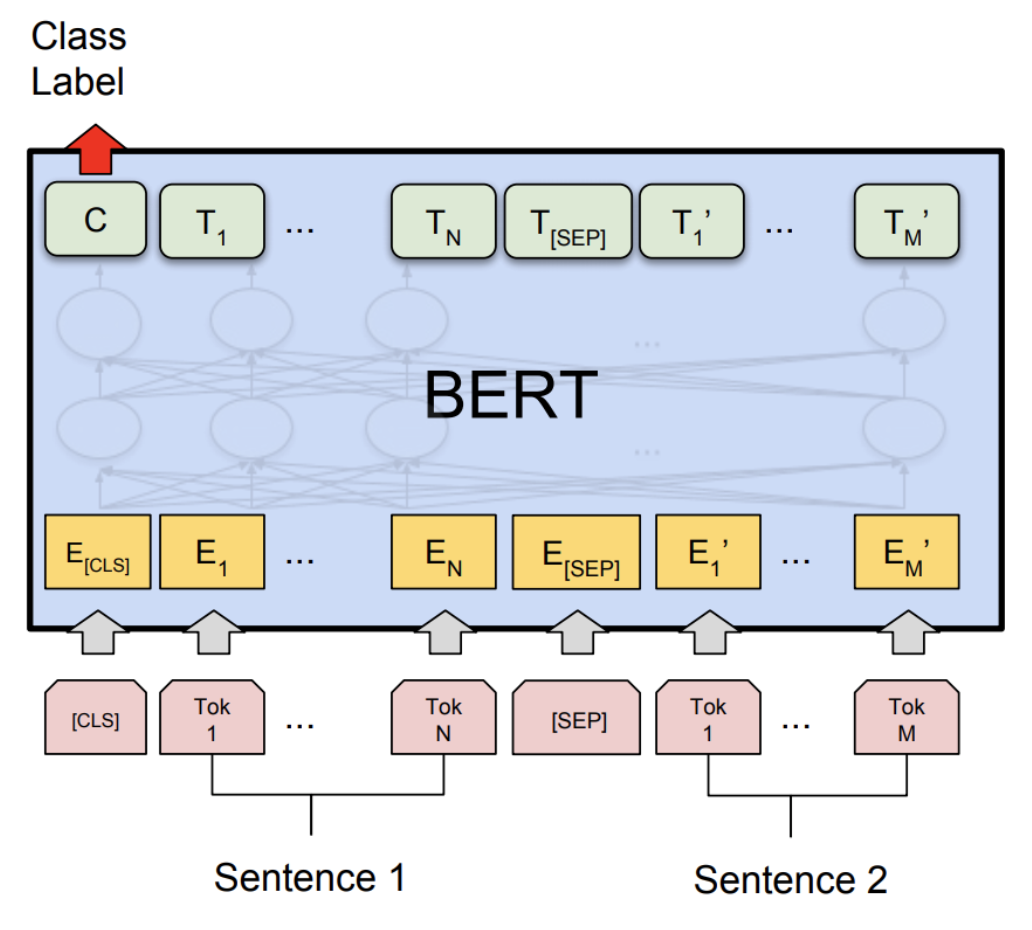

In [ ]:
# TODO: download a tokenizer and  preprocess our data

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
train_seqs = ['[CLS]' + d['questions']['text'][0] + '[SEP]' + d['questions']['text'][1] for d in ds]
train_tokens = [tokenizer.tokenize(seq) for seq in train_seqs]

In [ ]:
MAX_LEN = 128
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in train_tokens],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in train_tokens]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
input_ids.shape

In [ ]:
ds = ds.add_column('input_ids', input_ids.tolist())

In [ ]:
ds = ds.class_encode_column('is_duplicate')
ds = ds.rename_column('is_duplicate', 'labels')

In [ ]:
assert "input_ids" in ds.features
assert "labels" in ds.features
assert type(ds.features['labels']) == ClassLabel

In [ ]:
# DO NOT CHANGE ANYTHING HERE
ds = ds.train_test_split(test_size=0.2, stratify_by_column='labels', seed=42)
assert len(ds["test"]) == 80858

## Обучение модели (2 балла)

В выборе модели у вас относительная свобода - можете выбирать любую из моделей, основанных на слое Encoder трансформера. Можете использовать предобученные модели, замораживать веса, добавлять слои - все, на что хватит воображения и что даст скор получше.

In [ ]:
train_attention_masks = []
test_attention_masks = []

for seq in tqdm(ds['train']['input_ids']):
    seq_mask = [float(i>0) for i in seq]
    train_attention_masks.append(seq_mask)

for seq in tqdm(ds['test']['input_ids']):
    seq_mask = [float(i>0) for i in seq]
    test_attention_masks.append(seq_mask)

In [ ]:
# TODO: declare and train your model
device = 'cuda'
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

In [ ]:
train_inputs = torch.tensor(ds['train']['input_ids'])
validation_inputs = torch.tensor(ds['test']['input_ids'])

train_labels = torch.tensor(ds['train']['labels'])
validation_labels = torch.tensor(ds['test']['labels'])

train_masks = torch.tensor(train_attention_masks)
validation_masks = torch.tensor(test_attention_masks)

In [ ]:
batch_size = 64
epochs = 3

In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

In [ ]:
train_loss_set = []
model.cuda()

loss = torch.nn.CrossEntropyLoss()
for _ in trange(epochs, desc="Epoch"):  
    # model.train()   

    # tr_loss = 0
    # nb_tr_examples, nb_tr_steps = 0, 0

    # for step, batch in tqdm(enumerate(train_dataloader)):
        
    #     batch = tuple(t.to(device) for t in batch)
    #     b_input_ids, b_input_mask, b_labels = batch

    #     optimizer.zero_grad()
    #     loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    #     train_loss_set.append(loss.item())    
    #     loss.backward()
    #     optimizer.step()
    #     tr_loss += loss.item()
    #     nb_tr_examples += b_input_ids.size(0)
    #     nb_tr_steps += 1
    # print("Train loss: {}".format(tr_loss/nb_tr_steps))
        
    
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    
    for batch in tqdm(validation_dataloader):
    
        batch = tuple(t.to(device) for t in batch)
    
        b_input_ids, b_input_mask, b_labels = batch
    
        with torch.no_grad():
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    
        logits = logits.detach().cpu()#.numpy()
        label_ids = b_labels.to('cpu')#.numpy()
        
        tmp_eval_accuracy = loss(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

## Создание пайплайна (1 балл)

Здесь вам нужно создать пайплайн, который мог бы принять на вход два отдельных предложения в виде строк и выдать ответ True, если эти два предложения являются дублирующимися вопросами и False иначе.

In [ ]:
# TODO: implement your pipeline

def pipeline(sent1, sent2) -> bool:
    input_seq = tokenizer.tokenize('[CLS]' + sent1 + '[SEP]' + sent2)
    input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(input_seq)],
                              maxlen=MAX_LEN,
                              dtype="long",
                              truncating="post",
                              padding="post")
    input_ids = tokenizer.convert_tokens_to_ids(input_seq)
    
    input_ids = torch.tensor(pad_sequences([input_ids], maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")).to('cpu')
    
    seq_mask = torch.tensor([float(i>0) for i in input_ids[0]]).to('cpu').unsqueeze(0)

    model.eval()
    with torch.no_grad():
        logits = model(input_ids, token_type_ids=None, attention_mask=seq_mask)    
    logits = logits.detach().cpu()
    return torch.nn.functional.softmax(logits)[0][1].item() > 0.5

pipeline("What's the best way to learn English?",
                     "How can I learn to speak fluent English?")

In [ ]:
assert type(pipeline("What's the best way to learn English?",
                     "How can I learn to speak fluent English?")) == bool

## Отчёт (1 балл)

Здесь в свободной форме можно составить отчет о процессе и результатах работы. Вопросы для вдохновения: 

*   Что пробовали сделать?
*   Что получилось хорошо?
*   Что не получилось сделать? Почему?
*   Что можно было бы еще попробовать? Как улучшить результат?

Туду: писать тут

## Проверка результатов (5 баллов).

Проверим качество получившейся модели. Чтобы получить оценку 5, достаточно просто сделать модель, которая будет работать и что-то выдавать. Чтобы получить баллы за результаты, нужно набрать logloss на тестовой выборке ниже 0.25. Чтобы получить 5 баллов, нужно набрать logloss не выше 0.15. Любое значение logloss между 0.15 и 0.25 оценивается пропорционально (points = (0.25 - your_score) * 50).

In [ ]:
## TODO: calculate log-loss on df['test']
model.eval()
    
eval_loss = 0

for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = log_loss(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
score = eval_accuracy/nb_eval_steps

mark = min([(0.25 - score) * 50, 5])

## Бонус - использование Сиамских сетей (5 баллов)*

Для задач определения похожести пар (особенно пар изображений) нередко используют архитектуру Сиамских сетей. Ее суть заключается в том, что к каждому из двух входов модели применяются две идентичные подмодели с общим набором весов. Результаты применения этих подмоделей к двум предложениям сравниваются с помощью определенной метрики, которую считаем расстоянием. Итоговая модель стремится сделать так, чтобы расстояния между полученными векторами предложений одного класса были макисмально близки, а расстояние между векторами предложений разных классов - максимально далеки. Реализуется это с помощью, например, Triplet Loss или Contrastive Loss.

Подробнее о Сиамских сетях можно почитать [здесь](https://www.projectpro.io/article/siamese-neural-networks/718#mcetoc_1gke10clo18).

Ваша задача - реализовать Сиамскую сеть для нашей задачи определения схожих вопросов и сравнить результаты ее работы с результатами работы обычного трансформера.

Можете использовать любые инструменты и библиотеки, главное - результат.

In [ ]:
# TODO: Implement the Siamese Network architecture for QQP.